In [71]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import lightgbm as lgb
%matplotlib inline

# PART 1

## Simple Dataset

**1. load data**

In [2]:
simple_train = ['call you tonight', 'Call me a cab', 'please call me ... PLEASE !'] 
column=['text']

**Text preprocessing, remove punctuations, also lowercase all characters**

In [3]:
clean=[]
for txt in simple_train:
    remove_punc=[char for char in txt if char not in string.punctuation]
    clean.append(''.join(remove_punc).lower())
clean

['call you tonight', 'call me a cab', 'please call me  please ']

**2. use CountVectorizer() to "convert text into a matrix of token counts":** 

In [4]:
cv=CountVectorizer().fit(clean)

**3. transform training data into a 'document-term matrix' (which is a sparse matrix) use “transform()”**

In [5]:
sample_matrix=cv.transform(clean)

**4.print the sparse matrix**

In [6]:
print("Shape: ",sample_matrix.shape)
print(sample_matrix)

Shape:  (3, 6)
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


**5. convert the sparse matrix to a dense matrix use “toarray()”**

In [7]:
dense_matrix=sample_matrix.toarray()
dense_matrix

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

**6. examine the vocabulary and document-term matrix together use pandas DataFrame and columns by using “get_feature_names()**

In [8]:
pd.DataFrame(data=dense_matrix,columns=cv.get_feature_names(),index=clean)

,cab,call,me,please,tonight,you
call you tonight,0,1,0,0,1,1
call me a cab,1,1,1,0,0,0
please call me please,0,1,1,2,0,0


**7. transform testing data into a document-term matrix (using existing vocabulary)**

In [9]:
simple_test = ["please don't call me"] 

In [10]:
test_matrix=cv.transform(simple_test)
print(test_matrix)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1


**8. examine the vocabulary and document-term matrix together**

In [11]:
pd.DataFrame(data=test_matrix.toarray(),columns=cv.get_feature_names(),index=simple_test)

,cab,call,me,please,tonight,you
please don't call me,0,1,1,1,0,0


## Reading SMS data 

**9. read tab-separated file “sms.tsv”; give the names of columns as ['label', 'message']; and use head() to view part of the data**

In [12]:
df=pd.read_csv("sms.tsv", sep='\t',header=None,names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
len(df)

5572

**10. convert label to a numeric variable**

In [14]:
label_encode={'ham':0, 'spam':1}
df['label']=df['label'].map(label_encode)

In [15]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Preprocessing (Optional)**

This dataset is not yet clean, which contains punctuations, mixed cases, and some stopwords which are unecessary here.<br>

Preprocess the data first, hence I will write a function to remove any stopwords and punctuations, then lowercase all characters

In [16]:
def preprocessing(text):
    
    remove_punc=[txt for txt in text if txt not in string.punctuation]
    
    remove_punc=''.join(remove_punc).lower()
    
    return [clean for clean in remove_punc.split() if clean not in stopwords.words("english")]
    


**11. define X and y**

In [17]:
X=df['message']
y=df['label']

**12. split into training and testing sets by train_test_split(); and print the shape of training set and test set.**

In [18]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25, random_state=42)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4179,)
(4179,)
(1393,)
(1393,)


**13 instantiate the vectorizer by CountVectorizer()**

In [19]:
cv=CountVectorizer(analyzer=preprocessing)

**14. learn training data vocabulary, then create document-term matrix “X_train_dtm”**

In [20]:
X_train_dtm=cv.fit_transform(X_train,y_train)

In [21]:
print(X_train_dtm.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**15. transform testing data (using fitted vocabulary) into a document-term matrix**

In [22]:
X_test_trans=cv.transform(X_test)

**16. train a Naive Bayes model using the matrix “X_train_dtm”**

In [23]:
gnb = MultinomialNB()
gnb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
y_preds=gnb.predict(X_test_trans)

**17. calculate accuracy of predictions**

In [25]:
print("{:.0%}".format(accuracy_score(y_test, y_preds)))

99%


**18. give the confusion matrix**

In [26]:
cm=confusion_matrix(y_test, y_preds)

In [27]:
print(cm)

[[1202    5]
 [  15  171]]


**Visualisation (Optional)**

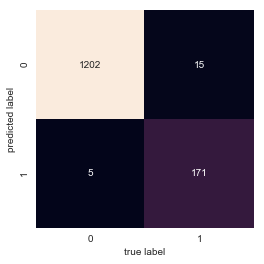

In [28]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

**Concat both messages and test set**

In [29]:
X_=df['message']
y_=df['label']

#This step is to make sure the sample being selected here is totally the same as the sample selected for training part
X_train_, X_test_, y_train_, y_test_=train_test_split(X_,y_,test_size=0.25, random_state=42)

In [30]:
print(y_test.shape)
print(y_preds.shape)
print(X_test_.shape)

(1393,)
(1393,)
(1393,)


In [31]:
X_test_=X_test_.reset_index()

In [32]:
X_test_.head()

,index,message
0,3245,Squeeeeeze!! This is christmas hug.. If u lik ...
1,944,And also I've sorta blown him off a couple tim...
2,1044,Mmm thats better now i got a roast down me! i...
3,2484,Mm have some kanji dont eat anything heavy ok
4,812,So there's a ring that comes with the guys cos...


In [33]:
y_test=y_test.reset_index()

In [34]:
y_test.head()

,index,label
0,3245,0
1,944,0
2,1044,0
3,2484,0
4,812,0


Convert predictive results to a Series

In [35]:
s1=pd.Series(y_preds)

In [36]:
validate=pd.concat([X_test_,y_test,s1],axis=1,ignore_index=True)
validate=validate.drop([0,2],axis=1).rename(columns={1:'message',3:'Actual',4:'Prediction'})
validate.head()

,message,Actual,Prediction
0,Squeeeeeze!! This is christmas hug.. If u lik ...,0,0
1,And also I've sorta blown him off a couple tim...,0,0
2,Mmm thats better now i got a roast down me! i...,0,0
3,Mm have some kanji dont eat anything heavy ok,0,0
4,So there's a ring that comes with the guys cos...,0,0


**19. print message text for the false positives**

In [37]:
print(validate[(validate.Actual == 0) & (validate.Prediction == 1)]['message'])

21                         Customer place i will call you
979                       Customer place i will call you.
1188          I am waiting machan. Call me once you free.
1336    We have sent JD for Customer Service cum Accou...
1347     Yavnt tried yet and never played original either
Name: message, dtype: object


**20. print message text for the false negatives**

In [38]:
print(validate[(validate.Actual == 1) & (validate.Prediction == 0)]['message'])

74      Oh my god! I've found your number again! I'm s...
84      Your next amazing xxx PICSFREE1 video will be ...
160     Babe: U want me dont u baby! Im nasty and have...
234     Hello darling how are you today? I would love ...
272     Do you realize that in about 40 years, we'll h...
324     Bloomberg -Message center +447797706009 Why wa...
530     A link to your picture has been sent. You can ...
550     Bloomberg -Message center +447797706009 Why wa...
561     Talk sexy!! Make new friends or fall in love i...
635     Sorry I missed your call let's talk when you h...
773     Am new 2 club & dont fink we met yet Will B gr...
1081    Email AlertFrom: Jeri StewartSize: 2KBSubject:...
1132    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
1175                             FROM 88066 LOST £12 HELP
1302    Did you hear about the new "Divorce Barbie"? I...
Name: message, dtype: object


# Part 2

**Loading Dataset**

In [19]:
from sklearn.datasets import load_boston

**1. First, use boston.corr() to show what features are correlated with each other**

In [20]:
boston = load_boston() 

In [21]:
df = pd.DataFrame(boston.data)

In [22]:
df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
1,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
2,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
3,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
4,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
5,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
6,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
7,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
8,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
9,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


**2. label the data and correlate it against each other**

In [15]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [22]:
df = pd.DataFrame(boston.data, columns=boston.feature_names) 
df['PRICE']=boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [17]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


**3. Visualize the correliation results**

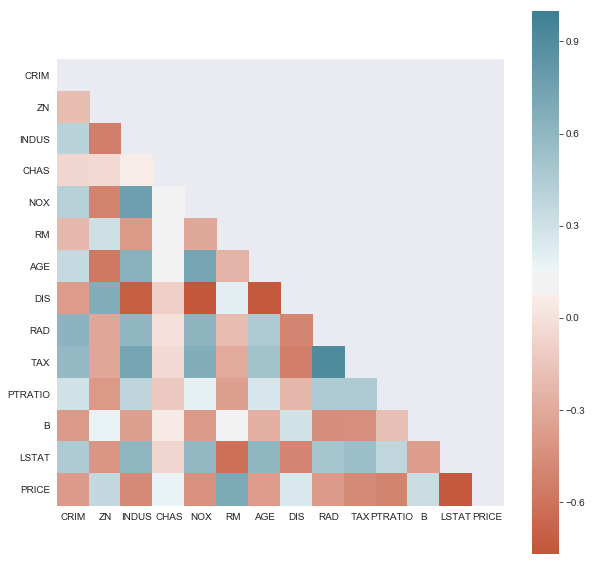

In [19]:
plt.figure(figsize=(10,10))
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
ax=sns.heatmap(df.corr(), 
               cbar=True, 
               cmap=sns.diverging_palette(20, 220, n=200), 
               square=True,
              
               mask=mask);
#ax.set_ylim(bottom + 0.5, top - 0.5)

**5. Split dataset into train/test set**

In [10]:
X=df.drop('PRICE', axis=1)
y=df['PRICE']

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=42)

**Convert Y set into log format in order to see more straightforward evaluation results (Optional)**

In [12]:
y_train=np.log(y_train)
y_test=np.log(y_test)

**5. Then creat a simple linear model**

In [13]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**7. coeficient**

In [14]:
lr.coef_

array([-1.07734718e-02,  7.05130150e-04,  3.14573733e-03,  9.52779182e-02,
       -6.53998939e-01,  1.07270274e-01, -2.67088082e-04, -4.61262541e-02,
        1.11432555e-02, -4.88210960e-04, -3.67248774e-02,  6.27241866e-04,
       -2.88011284e-02])

In [15]:
lr.intercept_

3.8147788462906957

**6. Predict the new results**

In [16]:
y_preds=lr.predict(X_test)

In [17]:
y_preds[0:10]

array([3.32599572, 3.61503538, 2.71540028, 3.25908693, 2.83689887,
       3.09926527, 2.85200944, 2.63558821, 3.05902822, 2.97733625])

**Score the model**

In [18]:
print(lr.score(X_test,y_test))

0.7468248298131477


**Use residual plots to see how model preform on both training data & test data**

In [19]:
def DistPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price of House')
    plt.ylabel('Proportion')

    plt.show()
    plt.close()

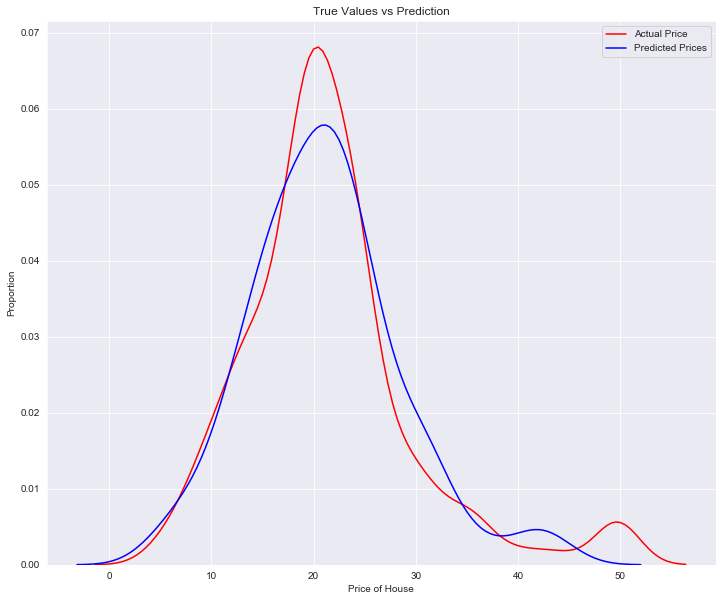

In [20]:
DistPlot(np.exp(y_test),np.exp(y_preds),"Actual Price", "Predicted Prices","True Values vs Prediction")

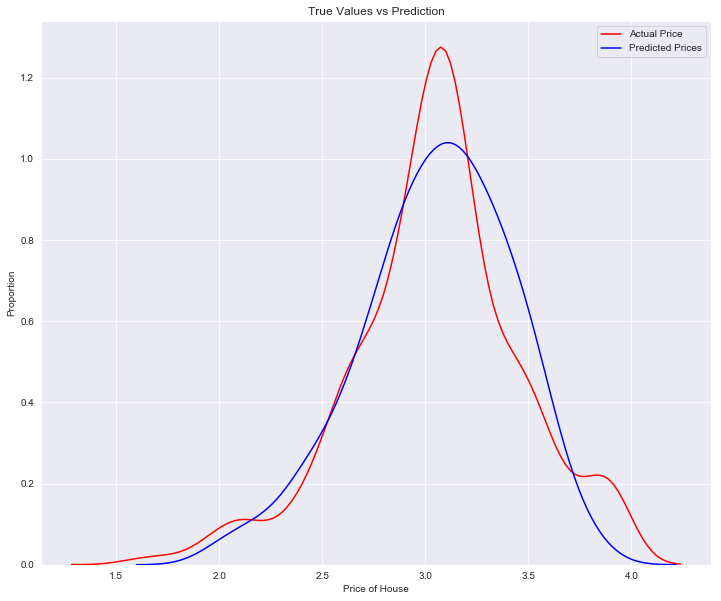

In [21]:
DistPlot(y_train,lr.predict(X_train),"Actual Price", "Predicted Prices","True Values vs Prediction")

Model Genarally performs well, while it is still a bit underfitting

**8.  please score the model against three metrics: R squared, mean squared error, and mean absolute error**

In [22]:
print("R-Squared: ",r2_score(y_test, y_preds))
print("MAE value: ",mean_absolute_error(y_test, y_preds))
print("MSE value: ",mean_squared_error(y_test, y_preds))
print("RMSE value: ",np.sqrt(mean_squared_error(y_test, y_preds)))

R-Squared:  0.7468248298131477
MAE value:  0.1312376872526138
MSE value:  0.03890003168440921
RMSE value:  0.19723090955630967


## Bonus: ways to imporve model performance

**Three options:**<br>
1. Features Scaling
2. Light BGM
3. Backward Elimination (Hypothesis Testing) 

In [69]:
X=df.drop('PRICE', axis=1)
y=df['PRICE']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=42)

Text(0.5, 1.0, 'R^2 Using Test Data')

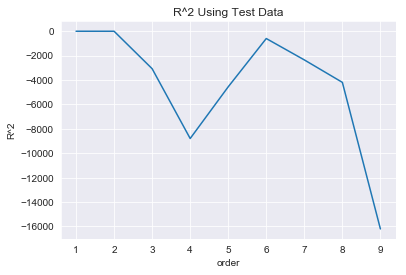

In [63]:
r2_score=[]
poly_order=range(1,10)
for n in poly_order:
    
    poly_features = PolynomialFeatures(degree=n)
    X_train_poly=poly_features.fit_transform(X_train)
    X_test_poly=poly_features.fit_transform(X_test)
    
    lr=LinearRegression()
    lr.fit(X_train_poly, y_train)
    
    #predict results on training set
    #y_train_predicted = lr.predict(X_train_poly)
    
    #oredict results on testing set
    #y_test_predict=lr.predict(X_test_poly)
    
    r2_score.append(lr.score(X_test_poly,y_test))
    
plt.plot(poly_order,r2_score)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')    
    

In [74]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly=poly_features.fit_transform(X_train)
#X_test_poly=poly_features.fit_transform(X_train_poly,y_train)
lr=LinearRegression()
lr.fit(X_train_poly,y_train)
poly_y_preds=lr.predict(poly_features.fit_transform(X_test))

In [75]:
#rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print(r2_score(y_test, poly_y_preds))

0.6844267283527113


In [68]:
y_preds

array([ 32.45236254,  41.50595903,  21.82709265,  10.44551563,
        10.83885765,  11.54741335,  17.75822783,  14.4380188 ,
         9.51189327,  24.51131392,   9.83868027,  23.79254675,
       -26.04114866,   8.94052887,  16.22313976,  19.07505655,
        18.99174118,   7.36452246,  44.1499567 ,  10.26873398,
        16.57134247,  23.5157671 ,   6.92379189,  15.58583927,
        18.17601347,  13.14737797,  10.97931337,  14.09667349,
         8.2162838 ,  23.24028063,  25.99398851,  22.60902882,
        29.37954378,  21.76394176,   9.08514166,  21.79635763,
        28.73771811,  17.15518427,  17.18958473,   8.33829498,
        21.04857254,  36.96250534,  47.14642096,  10.26960659,
        26.79480886,   9.82607889,   8.09618187,  10.28593826,
        10.04059982,  36.39827299,  21.29684162,  40.96020842,
        10.93812132,  28.10825634,  41.26470757,  28.16094589,
         7.26732969,  32.05564499,  20.91689301,  19.39445543,
        32.54959488,  21.71249437,  39.90671778,  -7.64

## Features Scaling

In [30]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [31]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Data is largely scaled, also it contains certain amount of outliers, so Robust Scaler is the relatively better way to normalize data

In [32]:
X=df.drop('PRICE',axis=1)
y=df['PRICE']

In [33]:
rb=RobustScaler()
X=rb.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25)

In [35]:
y_train=np.log(y_train)
y_test=np.log(y_test)

In [36]:
lr_f=LinearRegression()
lr_f.fit(X_train, y_train)
y_preds_f=lr_f.predict(X_test)

print out model accuracy

In [37]:
print(lr_f.score(X_test,y_test))

0.7911423740798529


In [38]:
print("R-Squared: ",r2_score(y_test, y_preds_f))
print("MAE value: ",mean_absolute_error(y_test, y_preds_f))
print("MSE value: ",mean_squared_error(y_test, y_preds_f))
print("RMSE value: ",np.sqrt(mean_squared_error(y_test, y_preds_f)))

R-Squared:  0.7911423740798529
MAE value:  0.14283302968941997
MSE value:  0.0448347384346195
RMSE value:  0.2117421508217471


Model Performance Improved

## LightGBM

In [39]:
X=df.drop('PRICE',axis=1)
y=df['PRICE']
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25)
y_train=np.log(y_train)
y_test=np.log(y_test)

In [40]:
train_set = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

In [41]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

bgm = lgb.cv(params, train_set=train_set, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42,stratified=False)

best_round = len(bgm['rmse-mean'])
print('Best rounds:\t', best_round)

Best rounds:	 999


**Visualize the rmse to see the changes as rounds goes up (Optional)**

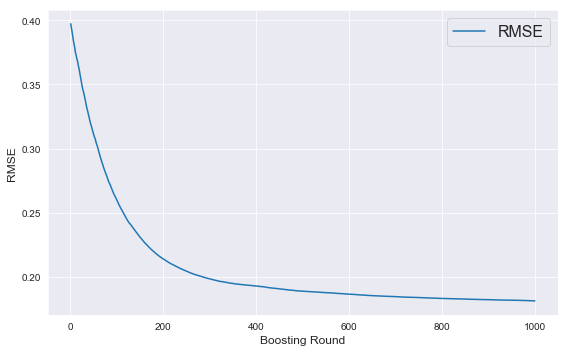

In [42]:
rmse = np.array(bgm['rmse-mean'])
std = np.array(bgm['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [45]:
clf = lgb.train(params, train_set=train_set, num_boost_round=best_round)
y_preds_lgb = clf.predict(X_test)

**Plot out all feature impotance (Optional)**

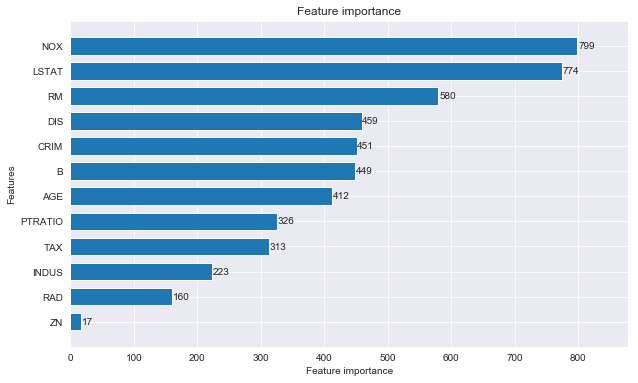

In [46]:
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()

In [47]:
print("R-Squared: ",r2_score(y_test, y_preds_lgb))
print("MAE value: ",mean_absolute_error(y_test, y_preds_lgb))
print("MSE value: ",mean_squared_error(y_test, y_preds_lgb))
print("RMSE value: ",np.sqrt(mean_squared_error(y_test, y_preds_lgb)))

R-Squared:  0.816522951987086
MAE value:  0.13556260207560752
MSE value:  0.03500048163727655
RMSE value:  0.18708415656403551


## Backward Elimination (Hypothesis Testing)

P Value : 0.05

In [24]:
X=df.drop('PRICE',axis=1)
y=df['PRICE']

In [25]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25)

In [26]:
X_train.shape

(379, 13)

In [27]:
X_train = np.append(arr=np.ones([X_train.shape[0],1]).astype(int), values = X_train, axis = 1)

In [28]:
X_train

array([[1.00000e+00, 2.54300e-02, 5.50000e+01, ..., 1.76000e+01,
        3.96900e+02, 7.18000e+00],
       [1.00000e+00, 3.04100e-02, 0.00000e+00, ..., 2.02000e+01,
        3.94810e+02, 1.05600e+01],
       [1.00000e+00, 1.08342e+01, 0.00000e+00, ..., 2.02000e+01,
        2.15700e+01, 2.57900e+01],
       ...,
       [1.00000e+00, 3.58400e-02, 8.00000e+01, ..., 1.61000e+01,
        3.96900e+02, 4.67000e+00],
       [1.00000e+00, 1.22472e+01, 0.00000e+00, ..., 2.02000e+01,
        2.46500e+01, 1.56900e+01],
       [1.00000e+00, 5.50070e-01, 2.00000e+01, ..., 1.30000e+01,
        3.87890e+02, 8.10000e+00]])

In [29]:
X_total = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
regressor = sm.OLS(y_train, X_train[:,X_total]).fit()
print(regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     85.99
Date:                Wed, 30 Oct 2019   Prob (F-statistic):          1.75e-102
Time:                        19:02:51   Log-Likelihood:                -1115.5
No. Observations:                 379   AIC:                             2259.
Df Residuals:                     365   BIC:                             2314.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1501      6.000      4.859      0.0

**the value of  x7 produces the highest p-value among all variables the p-value of which is above 0.05, so remove it for next step**

In [30]:
X_total = [0,1,2,3,4,5,6,8,9,10,11,12,13]
regressor = sm.OLS(y_train, X_train[:,X_total]).fit()
print(regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     93.34
Date:                Wed, 30 Oct 2019   Prob (F-statistic):          1.96e-103
Time:                        19:03:29   Log-Likelihood:                -1115.6
No. Observations:                 379   AIC:                             2257.
Df Residuals:                     366   BIC:                             2308.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5260      5.934      4.975      0.0

**Remove x3**

In [31]:
X_total = [0,1,2,4,5,6,8,9,10,11,12,13]
regressor = sm.OLS(y_train, X_train[:,X_total]).fit()
print(regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     101.9
Date:                Wed, 30 Oct 2019   Prob (F-statistic):          2.33e-104
Time:                        19:04:45   Log-Likelihood:                -1115.8
No. Observations:                 379   AIC:                             2256.
Df Residuals:                     367   BIC:                             2303.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.4518      5.929      4.968      0.0

**Re-construct the model**

In [32]:
X=df.drop(['AGE','INDUS'],axis=1)
y=df['PRICE']
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.25)

In [33]:
y_train=np.log(y_train)
y_test=np.log(y_test)

In [34]:
lr_b=LinearRegression()
lr_b.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
y_preds_b=lr_b.predict(X_test)

In [36]:
lr_b.score(X_test,y_test)

0.9611321433266096

In [37]:
print("R-Squared: ",r2_score(y_test, y_preds_b))
print("MAE value: ",mean_absolute_error(y_test, y_preds_b))
print("MSE value: ",mean_squared_error(y_test, y_preds_b))
print("RMSE value: ",np.sqrt(mean_squared_error(y_test, y_preds_b)))

R-Squared:  0.9611321433266095
MAE value:  0.052877814755005456
MSE value:  0.006001583307864337
RMSE value:  0.07746988645831576


**Overall, backward elimination does the best job here**